# 오차역전파법 backpropagation
- 계산그래프
- 연쇄법칙
- 역전파
- 단순한 계층 구현
- 활성화 함수 계층 구현
- Affine/Softmax 계층 구현
- 오차역전파법 구현하기

## 개요 

4장에서는 신경망 매개변수의 기울기(정확히는 W, b들에 대한 손실 함수의 기울기)를 수치 미분을 통해 구했다.  
단순하고 구현이 쉽지만 계산 시간이 오래 걸린다.

> 진짜 1만번 반복중 1번 반복에 30초씩 걸렸는데 오차역전파법을 사용하니 5초만에 1만번 반복이 끝났다.

오차역전파법을 이해하는 방법엔 두 가지가 있다.  
하느는 수식을 통한 것, 하나는 계산 그래프를 통한 것  
대부분은 전자로 설명하지만 여기선 그래프를 통해 **시각적**으로 이해해보자.

## 계산그래프

## 연쇄법칙

## 역전파

책 내용이라 생략  
계산 그래프가 이해하기 쉬었으나 수식으로 배우는게 더 멋짐  
스터디에서 `@simnalamburt`님의 발표로 수식으로 배움

## 단순한 계층 구현

## 활성화 함수 계층 구현

## Affine/Softmax 계층 구현

In [1]:
%pycat layers.py

## 오차역전파법 구현하기

In [4]:
import numpy as np
from collections import OrderedDict
from layers import SoftmaxWithLoss, Affine, Relu
from common.gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = None
        self.layers = None
        self.last_layer = None
        
        self.init_params(input_size, hidden_size, output_size, weight_init_std)
        self.init_layers()
        
    def init_params(self, input_size, hidden_size, output_size, weight_init_std):
        self.params = {}
        self.params["W1"] = np.random.randn(input_size, hidden_size) * weight_init_std
        self.params["b1"] = np.zeros(hidden_size)
        self.params["W2"] = np.random.randn(hidden_size, output_size) * weight_init_std
        self.params["b2"] = np.zeros(output_size)
        
    def init_layers(self):
        self.layers = OrderedDict()
        self.layers["Affine1"] = Affine(self.params["W1"], self.params["b1"])
        self.layers["Relu"] = Relu()
        self.layers["Affine2"] = Affine(self.params["W2"], self.params["b2"])
        self.last_layer = SoftmaxWithLoss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        loss = self.last_layer.forward(y, t)
        return loss
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)  # 열을 하나로 축소
        if t.ndim != 1:  # one-hot-encoding == True
            t = np.argmax(t, axis=1)
        
        acc = np.sum(y == t) / x.shape[0]
        return acc
    
    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # 결과 저장
        grads = {}
        grads["W1"] = self.layers["Affine1"].dW
        grads["b1"] = self.layers["Affine1"].db
        grads["W2"] = self.layers["Affine2"].dW
        grads["b2"] = self.layers["Affine2"].db
        return grads
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads["W1"] = numerical_gradient(loss_W, self.params["W1"])
        grads["b1"] = numerical_gradient(loss_W, self.params["b1"])
        grads["W2"] = numerical_gradient(loss_W, self.params["W2"])
        grads["b2"] = numerical_gradient(loss_W, self.params["b2"])
        return grads
        

`layers` 모듈의 `SoftmaxWithLoss` 클래스에서 `backward()` 부분을 책의 구현에서 조금 바꿨다.  
책에서는 아래와 같이 구현했다.  
```python
def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx
```
이럴경우 정답 라벨인 `t`가 `one-hot-encoding`이 되어있지 않고 `[5, 0, 2]`같은 형식으로 주어졌을 경우  
`self.y - self.t` 이 부분에서 제대로 연산이 이루어 지지 않는다.  
그래서 만약 `t`를 검사해 `one-hot-encoding`이 되어있지 않을 경우 `[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]`의 형식으로 바꿔주는 부분을 추가했다.  
```python
def backward(self, dout=1):
        if self.t.ndim == 1:
            temp = np.zeros_like(self.y)
            temp[np.arange(temp.shape[0]), self.t] = 1
            self.t = temp
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx
```

### 오차역전파법 기울기 검증

In [9]:
import numpy as np
import mnist

dataset = mnist.load(normalize=True)

network = TwoLayerNet(784, 50, 10)

x_batch  = dataset["train_img"][:3]
t_batch = dataset["train_label"][:3]

grad_backprop = network.gradient(x_batch, t_batch)
grad_numerical = network.numerical_gradient(x_batch, t_batch)

In [10]:
for key in grad_backprop.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + " : " + str(diff))

b1 : 8.23419746016e-13
W1 : 2.17966673465e-13
b2 : 1.20792256753e-10
W2 : 8.3351886157e-13


### 오차역전파법 학습 구현

In [17]:
import numpy as np
import mnist

np.random.seed(0)

dataset = mnist.load(normalize=True, one_hot_label=True)
network = TwoLayerNet(784, 50, 10)

iters_num = 10000
train_size = dataset["train_img"].shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)  # 600

In [39]:
from time import time

print("iter\ttrain_acc\ttest_acc\tloss")
start = time()
for i in range(iters_num):
    mask = np.random.choice(train_size, batch_size)
    x = dataset["train_img"][mask]
    t = dataset["train_label"][mask]
    
    grad = network.gradient(x, t)
    
    for key in grad.keys():
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x, t)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x, t)
        test_acc = network.accuracy(dataset["test_img"], dataset["test_label"])
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("{:5}\t{:8.04}%\t{:8.04}%\t{}".format(i, train_acc*100, test_acc*100, loss))

elapsed = time() - start
print("경과시간 : %.3f초" % elapsed)

iter	train_acc	test_acc	loss
    0	   100.0%	   97.42%	0.007625497799475946
  600	    99.0%	    97.4%	0.021769863988346783
 1200	   100.0%	    97.4%	0.008484898298744546
 1800	   100.0%	   97.42%	0.015333534703443195
 2400	   100.0%	    97.4%	0.00778191393346404
 3000	   100.0%	   97.54%	0.012346575913625995
 3600	   100.0%	   97.43%	0.010657455152127708
 4200	    99.0%	   97.46%	0.026616039571580048
 4800	   100.0%	   97.57%	0.006127909928825205
 5400	   100.0%	   97.53%	0.01229057202456569
 6000	   100.0%	   97.56%	0.006984050450962351
 6600	   100.0%	    97.5%	0.0133212801942587
 7200	   100.0%	   97.63%	0.008119606019723015
 7800	   100.0%	   97.62%	0.0040247582809385864
 8400	   100.0%	   97.62%	0.005169623353400729
 9000	   100.0%	   97.54%	0.006350156384282134
 9600	   100.0%	   97.46%	0.009064879845322641
경과시간 : 37.192초


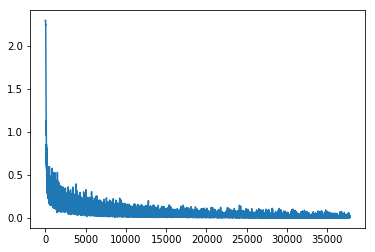

In [40]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list)
plt.show();

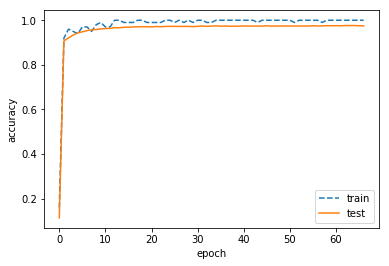

In [41]:
plt.plot(train_acc_list, linestyle="--", label="train")
plt.plot(test_acc_list, label="test")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show();

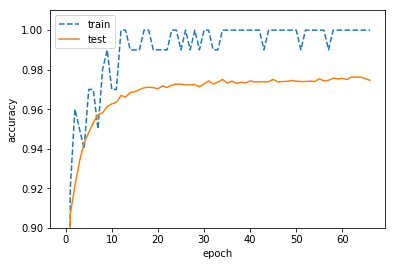

In [42]:
plt.plot(train_acc_list, linestyle="--", label="train")
plt.plot(test_acc_list, label="test")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim([0.9, 1.01])
plt.legend()
plt.show();

In [45]:
np.max(train_acc_list)
np.max(test_acc_list)
np.min(train_loss_list)

1.0

0.97629999999999995

0.0011825900849142354

### 다른 파라매터로 실험

In [52]:
import numpy as np
import mnist

np.random.seed(0)

dataset = mnist.load(normalize=True, one_hot_label=True)
network = TwoLayerNet(784, 200, 10)

iters_num = 10000
train_size = dataset["train_img"].shape[0]
batch_size = 100
learning_rate = 0.3

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)  # 600

In [53]:
from time import time

print("iter\ttrain_acc\ttest_acc\tloss")
start = time()
for i in range(iters_num):
    mask = np.random.choice(train_size, batch_size)
    x = dataset["train_img"][mask]
    t = dataset["train_label"][mask]
    
    grad = network.gradient(x, t)
    
    for key in grad.keys():
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x, t)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x, t)
        test_acc = network.accuracy(dataset["test_img"], dataset["test_label"])
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("{:5}\t{:8.04}%\t{:8.04}%\t{}".format(i, train_acc*100, test_acc*100, loss))

elapsed = time() - start
print("경과시간 : %.3f초" % elapsed)

iter	train_acc	test_acc	loss
    0	    33.0%	   27.59%	2.2897762986673302
  600	    94.0%	   93.83%	0.21458890980458625
 1200	    99.0%	   95.98%	0.058585702013295764
 1800	    99.0%	   96.72%	0.03879860793173921
 2400	    99.0%	   97.35%	0.03865740078521979
 3000	    99.0%	   97.46%	0.0343643363129568
 3600	   100.0%	   97.62%	0.014718309196885554
 4200	   100.0%	   97.76%	0.019309266627104065
 4800	    97.0%	   97.73%	0.0873631441685338
 5400	   100.0%	   97.81%	0.00881833075967906
 6000	   100.0%	   97.98%	0.007526397400749173
 6600	   100.0%	   97.99%	0.008516733161393796
 7200	   100.0%	   97.79%	0.00500533278600424
 7800	   100.0%	   98.14%	0.003172575815792326
 8400	   100.0%	    98.1%	0.008034533269384017
 9000	   100.0%	   98.13%	0.006389916258547389
 9600	    99.0%	   98.17%	0.016325238027135872
경과시간 : 127.124초


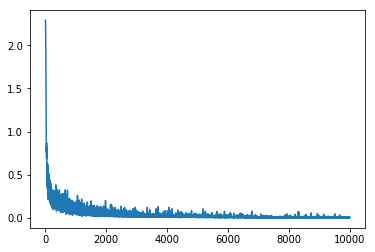

In [54]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list)
plt.show();

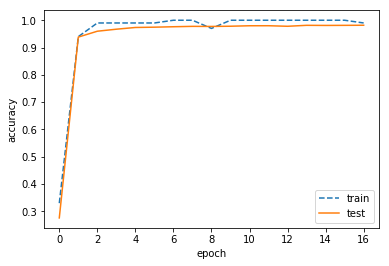

In [55]:
plt.plot(train_acc_list, linestyle="--", label="train")
plt.plot(test_acc_list, label="test")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show();

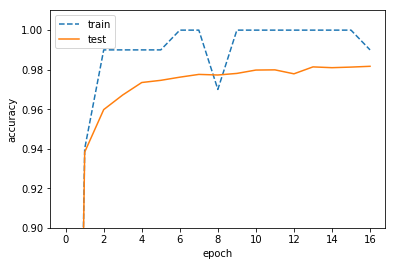

In [56]:
plt.plot(train_acc_list, linestyle="--", label="train")
plt.plot(test_acc_list, label="test")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim([0.9, 1.01])
plt.legend()
plt.show();

In [57]:
np.max(train_acc_list)
np.max(test_acc_list)
np.min(train_loss_list)

1.0

0.98170000000000002

0.00074500204197158098